In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import keras.api._v2.keras as keras
from keras import layers
import datetime
import time
from IPython import display

2023-04-12 11:04:59.188181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext tensorboard

Load and Preparing the Dataset

This block loads the mnist dataset into the variables train_images and train_labels, and normalizes the train_images to [-1,1]

Then buffers, and shuffles the data into the train_dataset

In [3]:
(train_images, train_lables), (_,_) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-04-12 11:05:06.587225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating the Generator Model

This model uses LeakyReLU activation functions for every layer excpet the output layer which uses tanh

The Dense Layer takes the input seed in to a dense layer of ~15,000 nodes, reshapes it into a 2d array of 7x7 with 256 values then uses convolutional layers to updscale the dimensions of the array, and decrease the bit depth until we reach 28x28x1

In [6]:
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.PReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Creating the generator object to create an image before training

In [7]:
generator = make_generator_model()

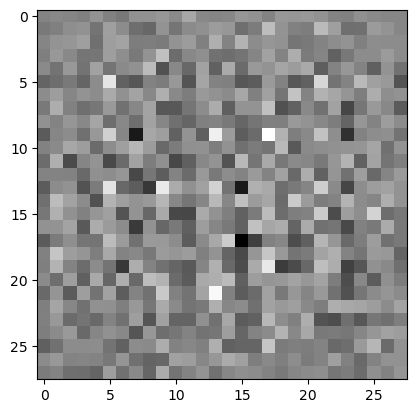

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Creating the Discriminator Model

Uses Conv2D layers to down sample the image, dropout layers to help prevent overfitting during training with a single dense layer at the output

In [9]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))

    model.add(layers.PReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.PReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.PReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the discriminator to classify the generated images as real or fake. 
output positive values for real images, negative values for fake images

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00010537]], shape=(1, 1), dtype=float32)


Defining the loss and optimizers

Get Helper function for computing cross entropy loss

In [11]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss

Quantifies how well the discriminator can distinguish between real and fake images. Compares Discriminator's real image predictions to an array of 1s and fake images to array of 0s

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

Generator loss

Quantifies how well the generator was able to trick the discriminator
The generator always thinks it is creating a real image so it always compares it to an array of ones

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

Save Checkpoints

Create save checkpoints so the model can be saved and recovered in the event that training is interrupted

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


Creating the training loop

First a couple hyper parameters for the training

In [16]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 25

Defining diagnostic metrics

In [17]:
gen_train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
#gen_train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')
disc_train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
#disc_train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

We create a seed which is reused during training to monitor the progress of the GAN

In [18]:
#seed will be reused when generating GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    gen_train_loss(gen_loss)
    disc_train_loss(disc_loss)

Creating and saving images

In [20]:
def generate_and_save_images(model, epoch, test_input):
    #training is set to false so all layers are run in interference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [19]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/'+current_time+'/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_train_loss.result(),step=epoch)
            tf.summary.scalar('disc_loss', disc_train_loss.result(),step=epoch)


        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        #save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} seconds'.format(epoch+1, time.time()-start))

        gen_train_loss.reset_states()
        disc_train_loss.reset_states()

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [22]:
%tensorboard --logdir logs/gradient_tape

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-04-12 11:05:25.684567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

To train the model we call the train() method, which will train both the generator and discriminator simultaneously.

In [25]:
train(train_dataset, EPOCHS)

ValueError: in user code:

    C:\Users\tasat\AppData\Local\Temp\ipykernel_27276\960142012.py:6 train_step  *
        generated_images = generator(noise, training=True)
    c:\Users\tasat\anaconda3\envs\oldTF\lib\site-packages\keras\engine\base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\tasat\anaconda3\envs\oldTF\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape (256, 50)


Restore last checkpoint

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Creating a GIF to show learning process

In [24]:
def display_image(epoch_no):
    return PIL.Image.open('img/image_at_epoch_{:04d}.png'.format(epoch_no))

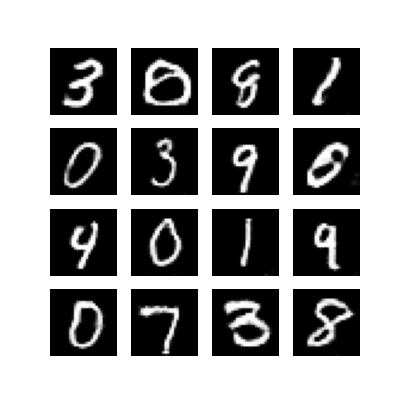

In [26]:
display_image(EPOCHS)

In [25]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('img/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/var/folders/xq/vmd9gzd93_l2b573jtw62yyr0000gn/T/ipykernel_8594/2514862315.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/xq/vmd9gzd93_l2b573jtw62yyr0000gn/T/ipykernel_8594/2514862315.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Generating image sample

In [26]:
def generate_images(model, test_input):
    #training is set to false so all layers are run in interference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,5))

    for i in range(predictions.shape[0]):
        plt.subplot(5,5,i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

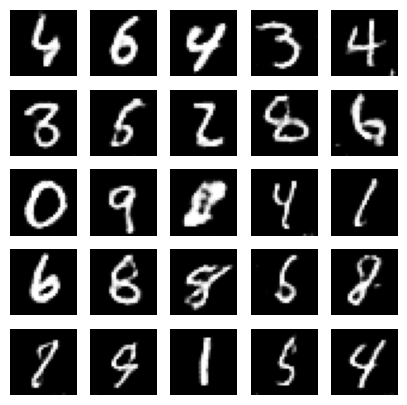

In [27]:
generate_images(generator, tf.random.normal([num_examples_to_generate, noise_dim]))